# 1. Install Dependencies and Setup

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove low quality images

In [5]:
import cv2
import imghdr

C:\Users\Kenneth\AppData\Local\Temp\ipykernel_29572\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 18 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

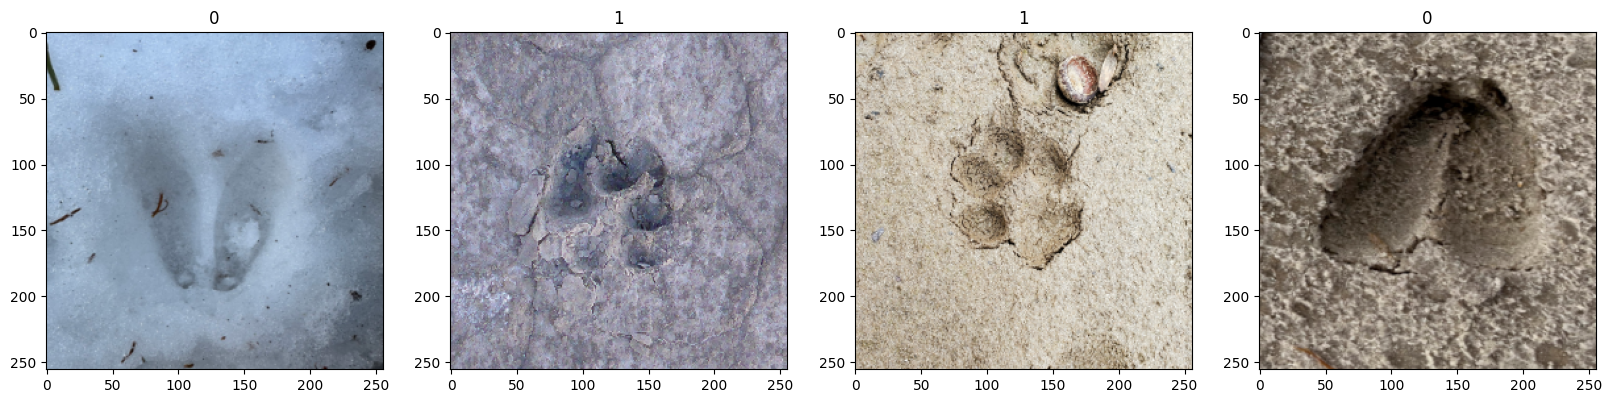

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.38058472, 0.3522273 , 0.25428504],
          [0.5443894 , 0.5100836 , 0.41814145],
          [0.5672957 , 0.5230325 , 0.4280598 ],
          ...,
          [0.5927745 , 0.5764115 , 0.4949421 ],
          [0.84803957, 0.8323533 , 0.7508199 ],
          [0.890003  , 0.87431675, 0.7927834 ]],
 
         [[0.51876867, 0.477493  , 0.38175875],
          [0.6409438 , 0.59527934, 0.49004805],
          [0.7302093 , 0.6828441 , 0.5816982 ],
          ...,
          [0.50925434, 0.49303314, 0.41736677],
          [0.413042  , 0.39735574, 0.3237264 ],
          [0.35486403, 0.33917776, 0.26566365]],
 
         [[0.7498291 , 0.6994275 , 0.60519063],
          [0.75051165, 0.7033014 , 0.59079134],
          [0.7934004 , 0.7464151 , 0.6421857 ],
          ...,
          [0.25387824, 0.23819198, 0.17104277],
          [0.1273842 , 0.11186583, 0.04519091],
          [0.19774158, 0.18240488, 0.11573821]],
 
         ...,
 
         [[0.53657204, 0.49372798, 0.41442955],
          [0.54584

# 5. Split Data

In [35]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [36]:
train_size

0

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

ValueError: Expected input data to be non-empty.

# 8. Plot Performance

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [ ]:
import cv2

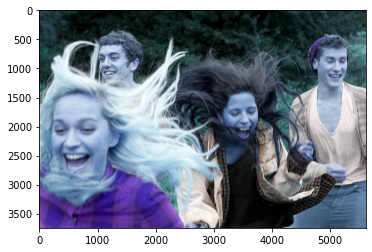

In [ ]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

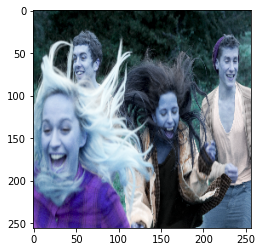

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

array([[0.01972741]], dtype=float32)

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)